### 🖋 **Notebook Contents**

0. Initial Setup
1. Exploratory Data Analysis (EDA)
2. Preprocessing

****

## `Initial Setup`

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import lines, patches
import matplotlib.pyplot as plt


from sklearn.impute import KNNImputer # imputasi missing values
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler # scaler

import missingno as msno

import warnings
warnings.filterwarnings("ignore")

from scipy.stats import shapiro # uji normalitas menggunakan metode shapiro
from scipy.stats import ks_2samp # uji statistik untuk mengetahui apakah terdapat perbedaan distribusi 2 kolom yang dibandingkan

# custom 'summer' colormap
import matplotlib
min_val, max_val = 1, 0
n = 10
orig_cmap = plt.cm.summer
colors = orig_cmap(np.linspace(min_val, max_val, n))
CUSTOM_SUMMER = matplotlib.colors.LinearSegmentedColormap.from_list("my cmap", colors)

# single color
COLOR = "#85bb65"

## `Exploratory Data Analysis`

EDA dilakukan untuk mengetahui distribusi data dan melihat bagaimana kondisi dataset yang dimiliki untuk pertimbangan analisa pada langkah berikutnya jika diperlukan

In [6]:
# copy dataset untuk EDA
data_eda = data.copy()

### 1. Plot Distribusi Data

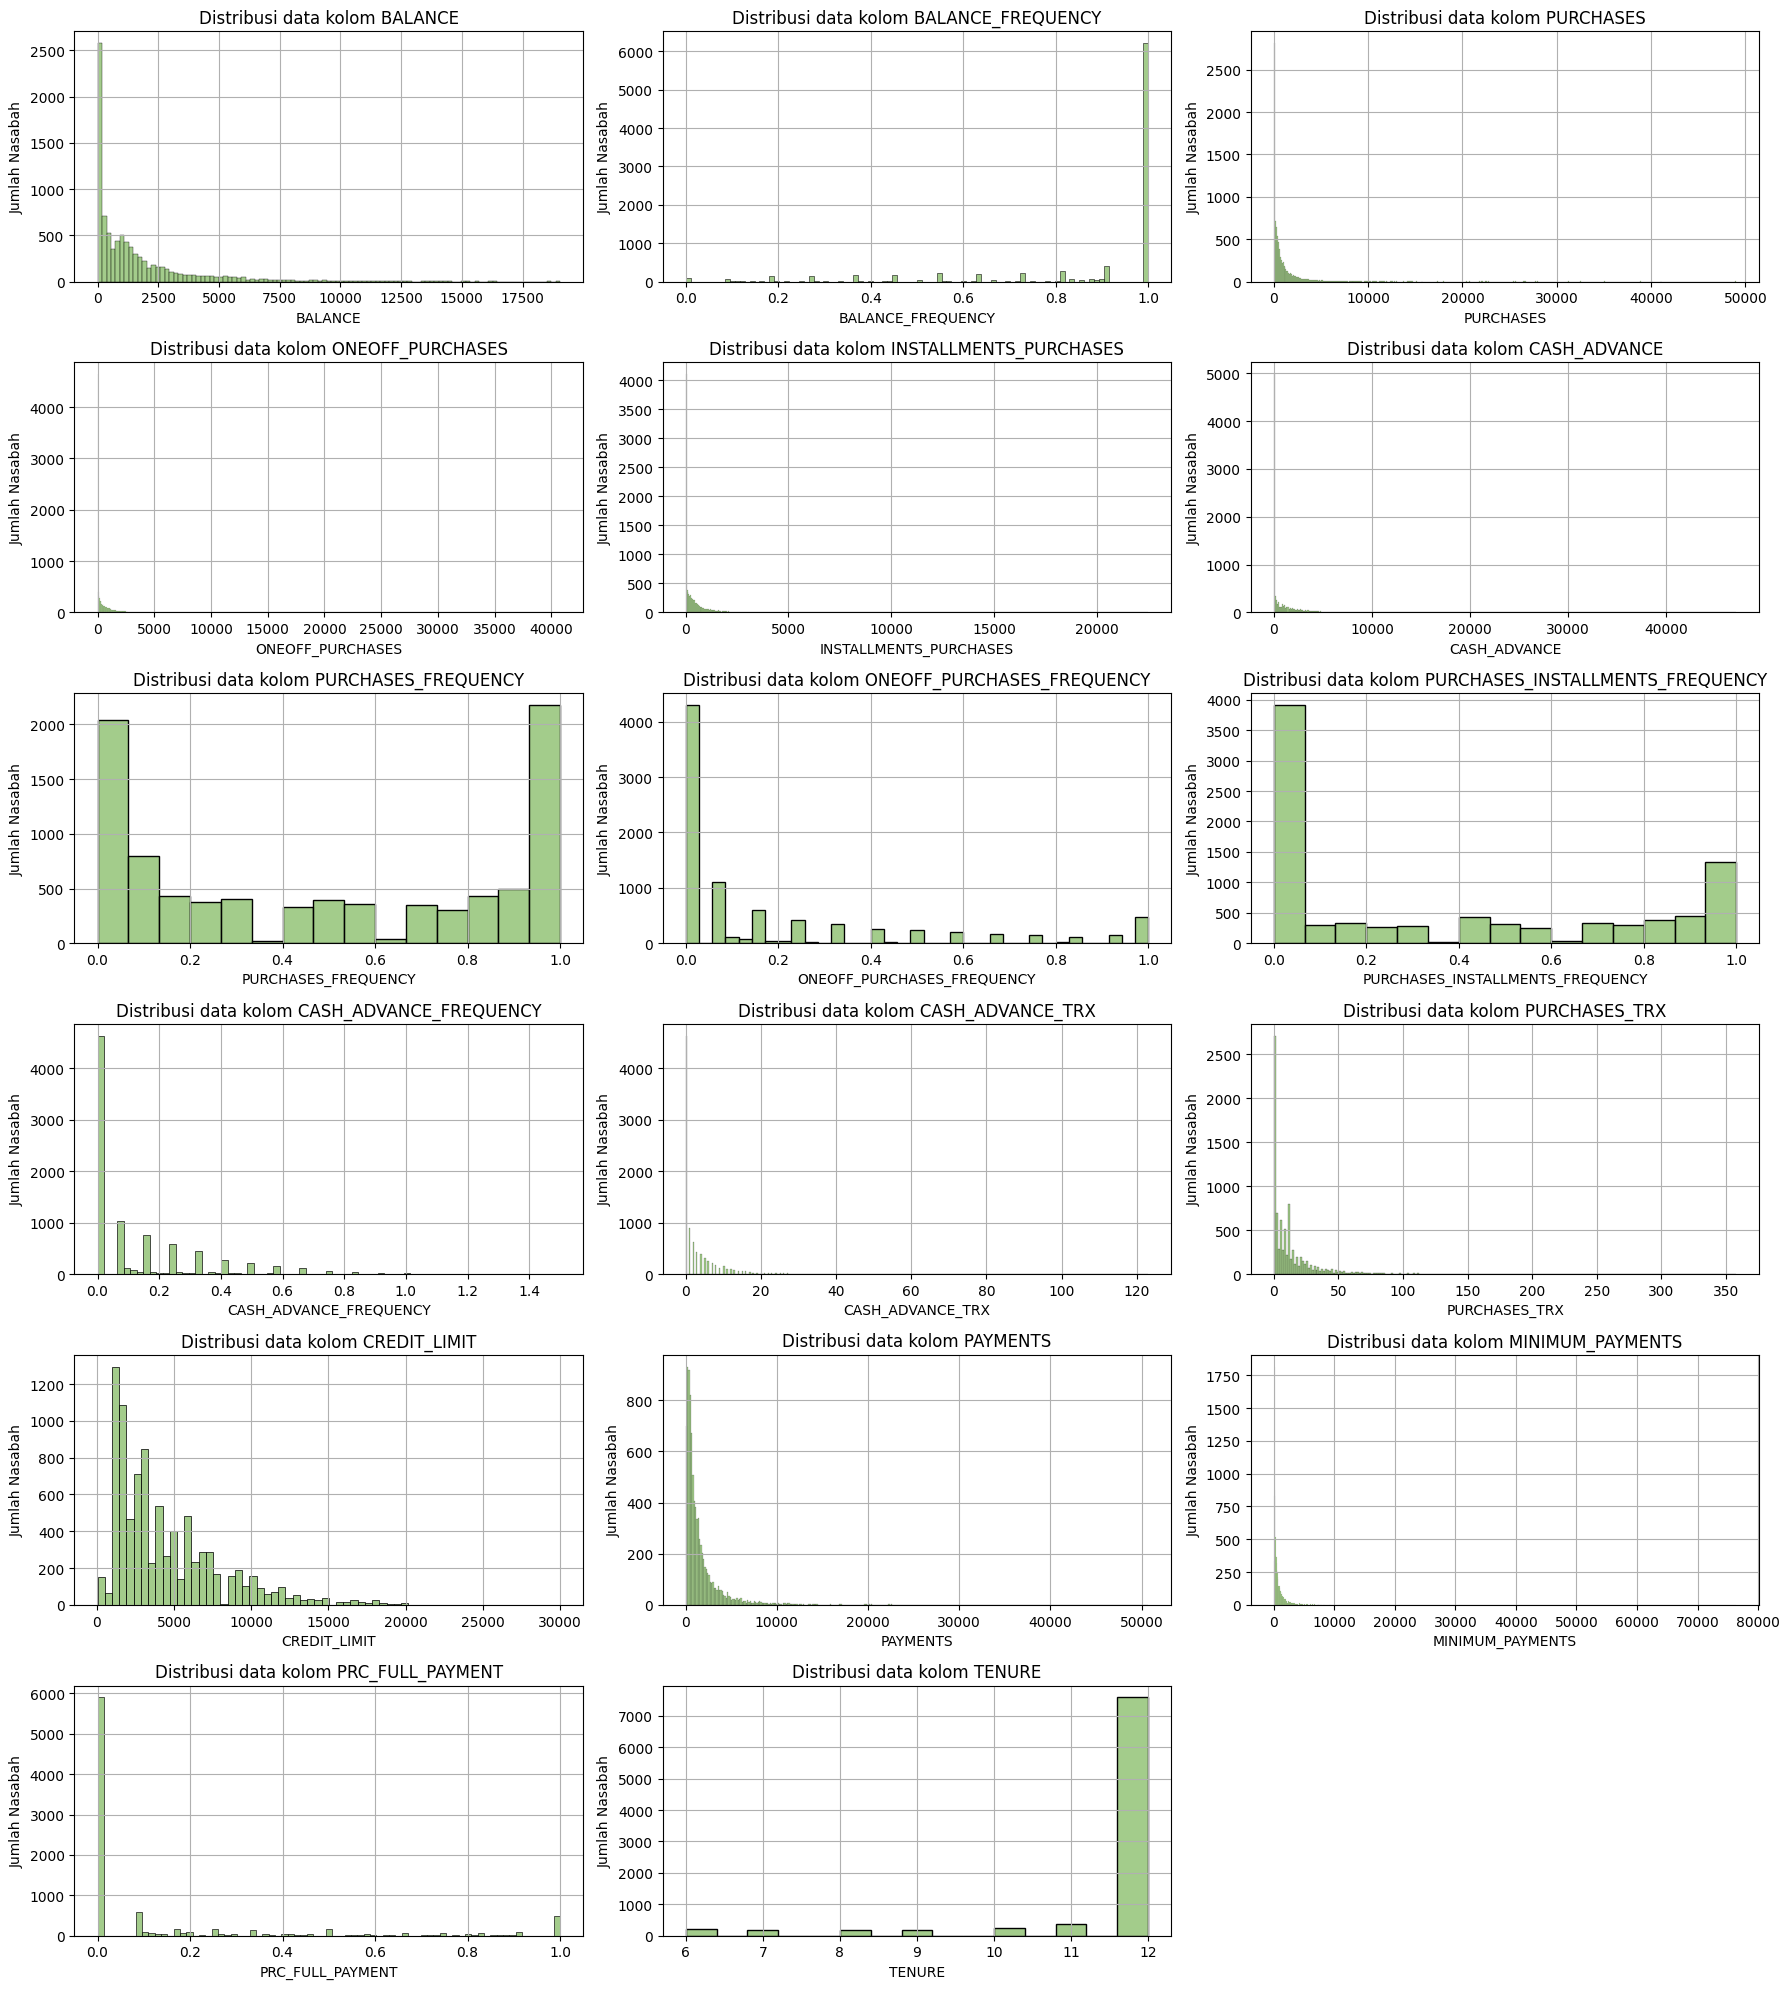

In [7]:
# plot distributi data dari semua kolom menggunakan histogram plot
count = 0
fig = plt.figure(figsize=(18, 20))
for feature in data_eda.drop(columns='CUST_ID').columns:
    count +=1
    ax = plt.subplot(6,3,count)
    sns.histplot(data=data_eda.drop(columns='CUST_ID'), x=feature, color=COLOR)
    plt.title(f"Distribusi data kolom {feature}")
    plt.ylabel("Jumlah Nasabah")
    fig.tight_layout()
    plt.grid(True)
plt.show()

**_Insight_**:
- Untuk kolom numerik yang bersifat continue, berdasarkan visualiasi di atas, terlihat jelas bahwa semua data tersebut bersifat **distribusinya tidak normal** dan memiliki sifat _right-skewed_. 
- Untuk kolom numerik yang bersifat ordinal, mayoritas nilainya adalah nol, kecuali pada kolom BALANCE_FREQUENCY, PURCHASES_FREQUENCY, dan TENURE. Pada kolom BALANCE_FREQUENCY mayoritas nilainya adalah satu, hal ini dapat terjadi karena para nasabah tersebut sering melakukan PURCHASES dan/atau PAYMENTS, sehingga BALANCE (available credit) juga akan sering ter-update. Pada kolom PURCHASES_FREQUENCY ada beberapa nasabah yang sama sekali tidak menggunakan kartu kredit (frekuensinya adalah 0), tetapi ada juga nasabah yang sering menggunakan kartu kredit (frekuensinya adalah 1). Mayoritas nasabah memilih TENURE yang 12 bulan. 
- .......
- .......

Referensi: 
- [Take Control of Credit Card Debt: Current Balance vs. Available Credit](https://upgradedpoints.com/credit-cards/current-balance-vs-available-credit/)
- [Available Credit: Meaning and Examples in Credit Cards](https://www.investopedia.com/terms/a/available-credit.asp#:~:text=Available%20credit%20refers%20to%20how,payments%20increase%20your%20available%20credit.)

In [8]:
# Cek menggunakan metode statistik shapiro test sebagai validasi apakah memang betul distribusinya tidak normal untuk data numerik yang bersifat continue

# kolom numerik yang bersifat continue
num_continue = ['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS']

# melakukan shapiro test
result_shapiro = []
for cols in num_continue:
    # pvalue selain kolom MINIMUM_PAYMENTS
    if cols not in ['MINIMUM_PAYMENTS', 'CREDIT_LIMIT']:
        stats, pvalue = shapiro(data_eda[cols])
        # check nilai p-value
        if pvalue > 0.05:
            result_shapiro.append({'kolom':cols, 'pvalue':pvalue, 'jenis_distribusi':'distribusi data normal'})
        else:
            result_shapiro.append({'kolom':cols, 'pvalue':pvalue, 'jenis_distribusi':'distribusi data tidak normal'})
    
    # pvalau kolom MINIMUM_PAYMENTS (terdapat nilai NaN, nilai p-value akan bias jika NaN values tidak dihapus)
    else:
        stats, pvalue = shapiro(data_eda[cols].dropna())
        # check nilai p-value
        if pvalue > 0.05:
            result_shapiro.append({'kolom':cols, 'pvalue':pvalue, 'jenis_distribusi':'distribusi data normal'})
        else:
            result_shapiro.append({'kolom':cols, 'pvalue':pvalue, 'jenis_distribusi':'distribusi data tidak normal'})
    

# display hasil uji statistik
shapiro_df = pd.DataFrame(result_shapiro)
shapiro_df

,kolom,pvalue,jenis_distribusi
0,BALANCE,0.0,distribusi data tidak normal
1,PURCHASES,0.0,distribusi data tidak normal
2,ONEOFF_PURCHASES,0.0,distribusi data tidak normal
3,INSTALLMENTS_PURCHASES,0.0,distribusi data tidak normal
4,CASH_ADVANCE,0.0,distribusi data tidak normal
5,CREDIT_LIMIT,0.0,distribusi data tidak normal
6,PAYMENTS,0.0,distribusi data tidak normal
7,MINIMUM_PAYMENTS,0.0,distribusi data tidak normal


**_Insight_**:
- Setelah melakukan **uji normalitas dengan metode shapiro**, terbukti bahwa semua kolom numerik yang bersifat continue distribusi datanya tidak normal karena memiliki nilai p-value kurang dari 0.05
- Cek korelasi antar kolom akan dilakukan dengan metode Spearman (non-parametric method)

### 2. Hubungan Antar Kolom

1. Plot persebaran data antara kolom satu dengan kolom lainnya menggunakan metode scatter plot
2. Melakukan cek korelasi data antar kolom menggunakan metode Spearman
3. Melihat bagaimana hubungan antar kolom dengan melakukan visualisasi data

#### 2.1. Persebaran Data Menggunakan Scatter Plot

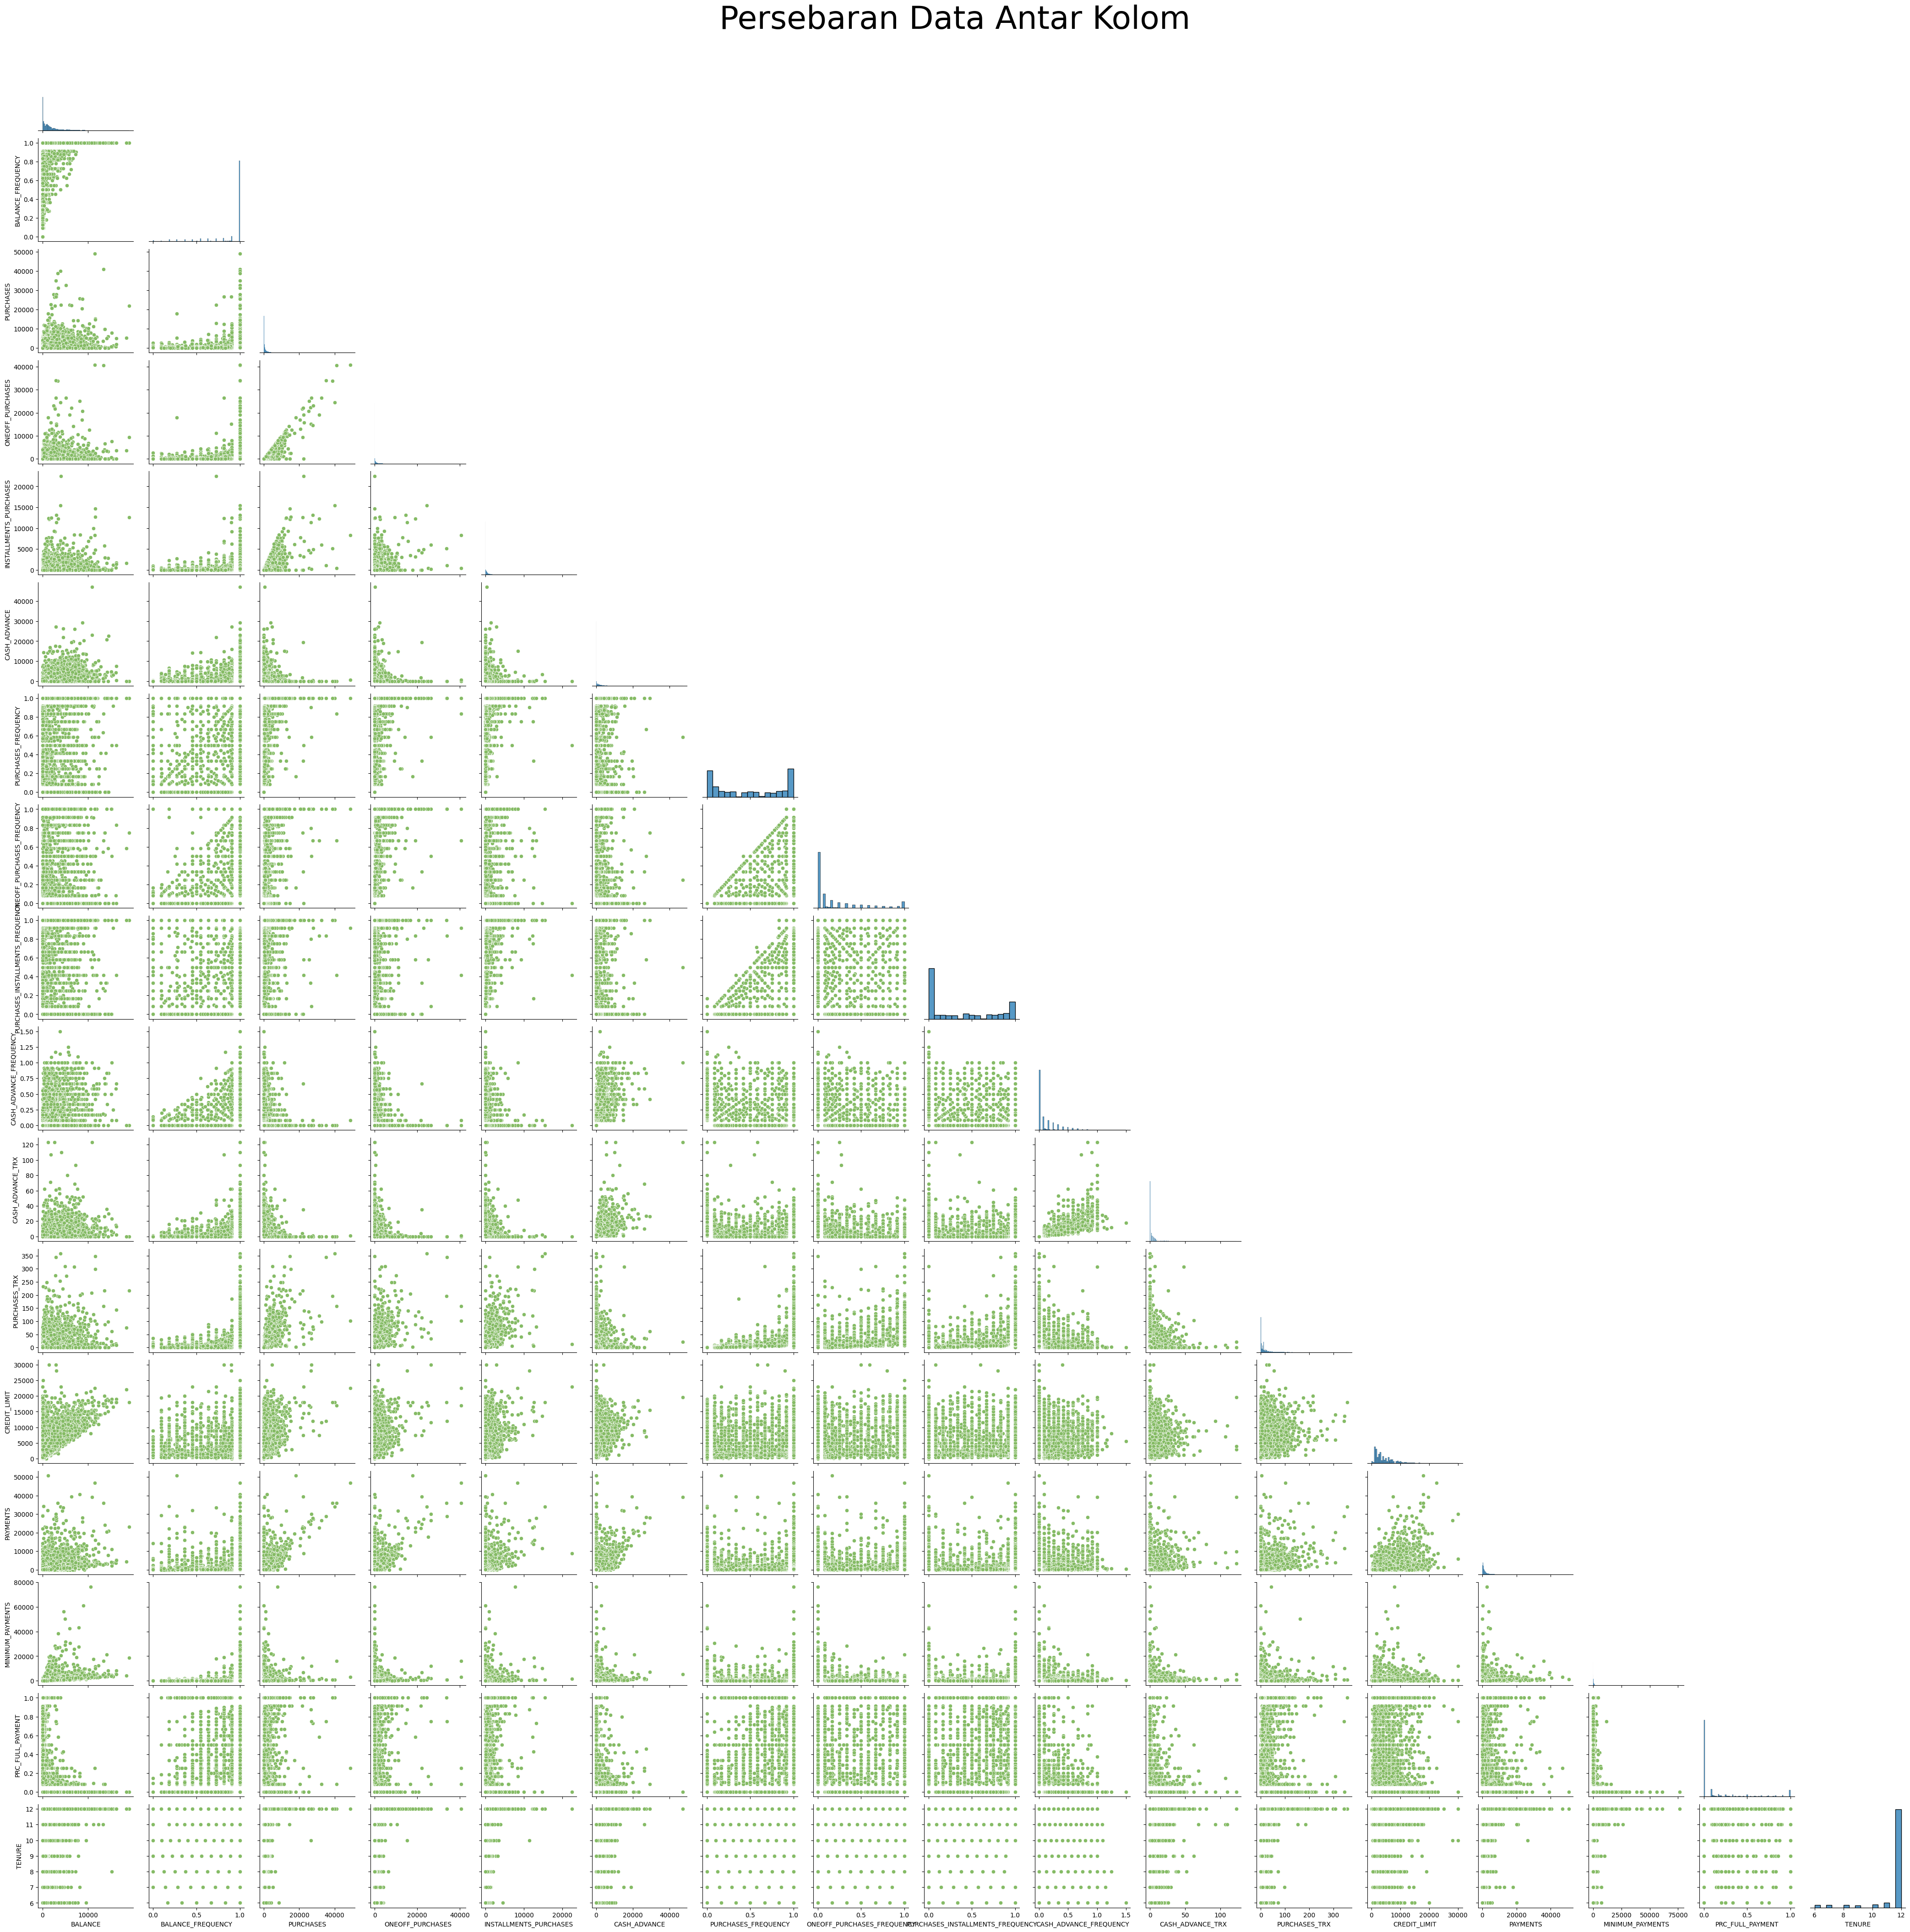

In [9]:
# plot persebaran data menggunakan scatter plot
grph = sns.pairplot(data_eda.drop(columns='CUST_ID'), corner=True, diag_kind='hist', plot_kws=dict(color=COLOR))
grph.fig.suptitle("Persebaran Data Antar Kolom", y=1, fontsize=50)
plt.show()

**_Insight_**:
- Terdapat beberapa kolom yang persebaran datanya memiliki sifat cenderung **linear**, misalnya antara kolom ONEOFF_PURCHASES dengan kolom PURCHASES, kolom INSTALLMENT_PURCHASES dengan kolom PURCHASES. dsb. Namun banyak juga kolom yang persebaran datanya memiliki sifat **non-linear**, misalnya antara kolom CREDIT_LIMIT dengan kolom-kolom yang merupakan frekuensi (PURCHASES_FREQUENCY, ONEOFF_PURCHASES_FREQUENCY, dsb)
- Terdapat beberapa data yang sifatnya _bivariate outlier_. Misalnya, antara kolom PURCHASES dengan kolom BALANCE, ada nasabah yang total pembeliannya besar, tapi sisa saldo kartu kredit yang masih bisa digunakan juga besar. Hal ini dapat terjadi karena PURCHASES dilakukan secara ONEOFF_PURCHASES (tagihannya langsung dibayarkan (lunas))
- .......
- .......

#### 2.2. Cek Korelasi Data Antar Kolom Menggunakan Metode Spearman

Output nilai yang dihasilkan adalah nilai antara -1 sampai 1. Jika nilai data pada variabel/kolom "A" **bertambah**, begitu pula pada variabel/kolom "B", maka nilai output yang dihasilkan akan semakin **mendekati 1 (positif) atau berkorelasi tinggi**, sedangkan jika yang terjadi adalah **sebaliknya (berkurang)**, maka nilai output yang dihasilkan akan semakin **mendekati -1 (negatif) atau berkorelasi tinggi, namun arahnya negatif**. Kemudian, jika nilai output yang dihasilkan **mendekati 0**, hal ini berarti data pada variabel/kolom "A" **tidak memiliki korelasi** dengan data pada variabel/kolom "B". ([referensi_1](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient#:~:text=The%20sign%20of,coefficient%20becomes%201.), [referensi_2](https://en.wikipedia.org/wiki/Monotonic_function))

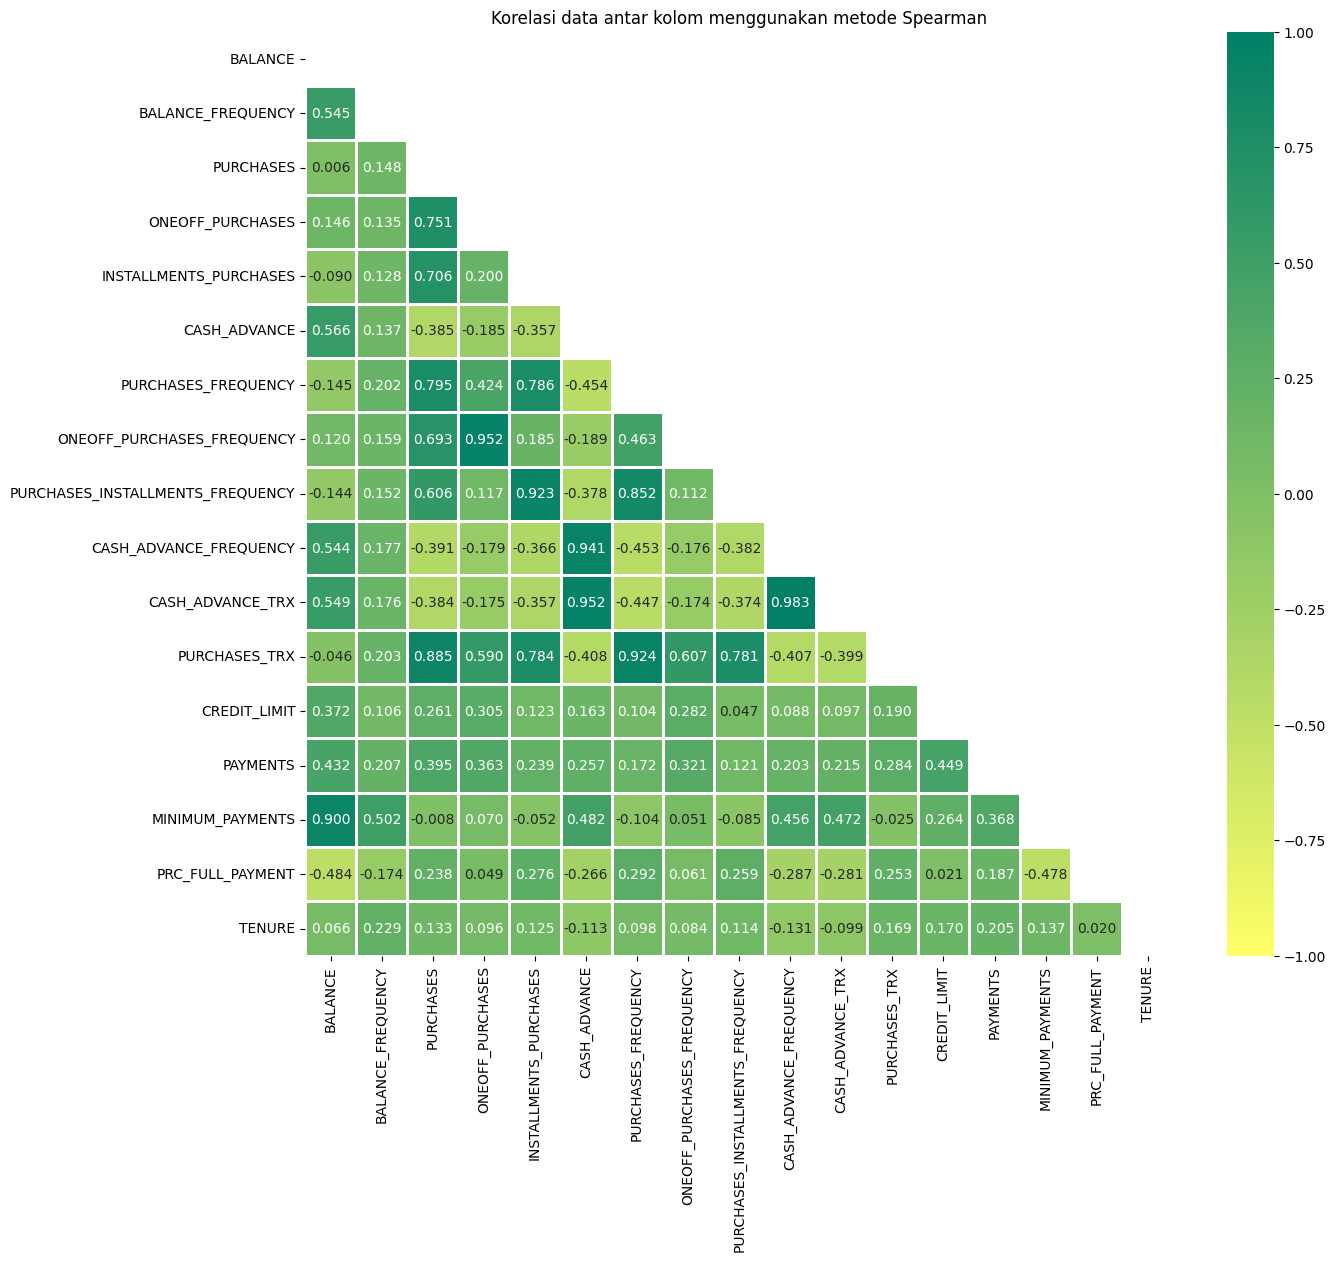

In [10]:
# cek korelasi data antar kolom menggunakan metode Spearman

# data nilai korelasi
matrix = np.triu(data_eda.drop(columns='CUST_ID').corr(method='spearman'))
# color map
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# plot data nilai korelasi menggunakan grafik heatmap
plt.figure(figsize=(14,12))
plt.title("Korelasi data antar kolom menggunakan metode Spearman")
sns.heatmap(data=data_eda.corr(method='spearman'), annot=True, fmt=".3f", cmap=CUSTOM_SUMMER, vmin=-1, vmax=1, mask=matrix, linewidths=2);

**_Insight_**:
- Terdapat beberapa pola yang memiliki kecenderungan yang sama, yaitu data yang berupa frekuensi atau jumlah transaksi memiliki nilai korelasi positif yang tinggi dengan data yang berkaitan dengan data itu sendiri. Contohnya dapat dilihat pada kolom CASH_ADVANCE_FREQUENCY berkorelasi tinggi (0.941) dengan kolom CASH_ADVANCE dan juga dengan kolom CASH_ADVANCE_TRX (0.983), kolom PURCHASES_FREQUENCY berkorelasi tinggi (0.795) dengan kolom PURCHASES dan juga dengan kolom PURCHASES_TRX (0.924), dsb.
- Terdapat juga nilai korelasi negatif yang sedikit cenderung linear, misalnya antara kolom PRC_FULL_PAYMENT dengan kolom MINIMUM_PAYMENTS (-0.478). Hal menunjukkan pola ada beberapa customer yang melakukan pembayaran (payment) yang nilainya semakin besar, tapi total presentase yang disudah dibayarkan semakin kecil.
- .......
- .......

#### 2.3. Melihat hubungan antar kolom dengan melakukan visualisasi data

>2.3.1. CREDIT_LIMIT vs PURCHASES, PAYMENTS, dan BALANCE

Melihat bagaimana pengaruh PURCHASES, PAYMENTS, dan BALANCE terhadap CREDIT_LIMIT nasabah

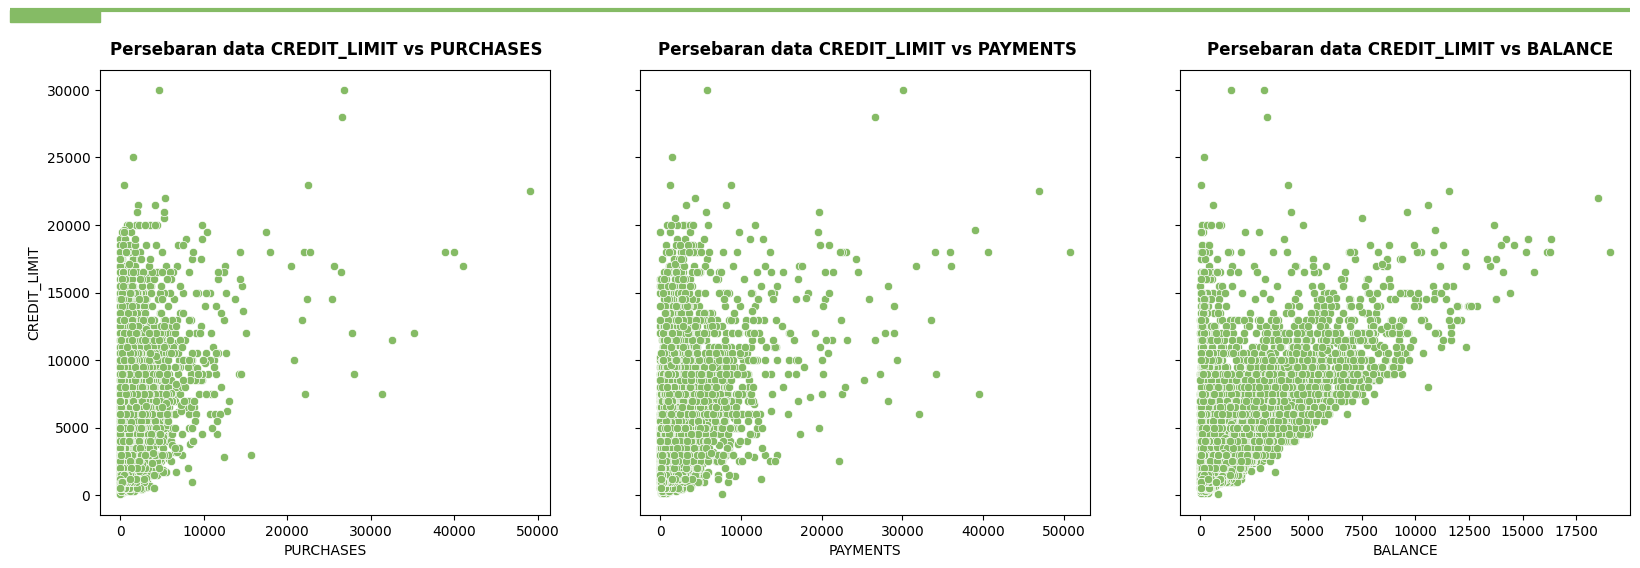

In [11]:
# melihat hubungan bagaimana CREDIT_LIMIT vs BALANCE dan CREDIT_LIMIT vs PAYMENTS dengan visualisasi grafik

# inisialisasi plot
fig, (ax1,ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,5), sharey=True)

# adjust subplot
plt.subplots_adjust(left=0.05, top=1)

# garis lurus dan bentuk persegi panjang di atas
fig.add_artist(lines.Line2D([0, 0.9], [1.12, 1.12], lw=3, color=COLOR, solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 1.095), 0.05, 0.025, color=COLOR))

# judul grafik
fig.text(0.0555, 1.03, "Persebaran data CREDIT_LIMIT vs PURCHASES", fontsize=12, fontweight="bold")
fig.text(0.36, 1.03, "Persebaran data CREDIT_LIMIT vs PAYMENTS", fontsize=12, fontweight="bold")
fig.text(0.665, 1.03, "Persebaran data CREDIT_LIMIT vs BALANCE", fontsize=12, fontweight="bold")

# display grafik
sns.scatterplot(data=data_eda, x='PURCHASES', y='CREDIT_LIMIT', color=COLOR, ax=ax1)
sns.scatterplot(data=data_eda, x='PAYMENTS', y='CREDIT_LIMIT', color=COLOR, ax=ax2)
sns.scatterplot(data=data_eda, x='BALANCE', y='CREDIT_LIMIT', color=COLOR, ax=ax3)

plt.show();

**_Insight_**:
- Ada beberapa pola yang terbentuk, antara lain:
    - Pola semakin besar CREDIT_LIMIT, semakin besar pula BALANCE. Hal ini menunjukkan bahwa terdapat nasabah yang memiliki CREDIT_LIMIT besar, sisa saldo yang masih dapat digunakan juga besar (kedua variabel cenderung semakin besar). Atau dengan kata lain, nasabah tersebut **jarang menggunakan kartu kreditnya** atau nasabah tersebut **sering melakukan pembelian (PURCHASES) dan membayar sesuai tagihannya (PAYMENTS)**
    - Namun, ada juga nasabah yang memiliki CREDIT_LIMIT besar, tapi **tidak ada** sisa saldo yang masih dapat digunakan. Atau dengan kata lain, nasabah tersebut nasabah yang memiliki CREDIT_LIMIT besar, nasabah tersebut cenderung **sering menggunakan kartu kredit**, bahkan sampai tidak ada saldo yang tersisa, tapi **tidak membayar tagihannya (PAYMENTS = 0)**

Referensi:
- [How Credit Card Companies Determine Credit Limit](https://www.investopedia.com/articles/credit-loans-mortgages/081516/how-credit-card-companies-determine-credit-limit-expn.asp#:~:text=What%20Affects%20Your,on%20your%20report.)
- [What Is a Credit Limit? How It's Determined and How to Increase It](https://www.investopedia.com/terms/c/credit_limit.asp#citation-3:~:text=3-,Can%20Lenders%20Change%20Your%20Credit%20Limit%3F,-In%20most%20cases)

>2.3.2. Bagaimana jenis-jenis nasabah jika dilihat dari metode/cara mereka melakukan pembelian ? Apakah secara langsung lunas (ONEOFF) dan/atau secara angsuran (INSTALLMENTS) ?

In [12]:
# membuat fungsi sebagai conditional statments pada kolom baru PURCHASES_TYPE
def purchases_type(df: pd.DataFrame):
    if df['ONEOFF_PURCHASES'] == 0 and df['INSTALLMENTS_PURCHASES'] == 0: return 'NO PURCHASES'
    elif df['ONEOFF_PURCHASES'] > 0 and df['INSTALLMENTS_PURCHASES'] > 0: return 'BOTH'
    elif df['ONEOFF_PURCHASES'] > 0 and df['INSTALLMENTS_PURCHASES'] == 0: return 'ONEOFF'
    elif df['ONEOFF_PURCHASES'] == 0 and df['INSTALLMENTS_PURCHASES'] > 0: return 'INSTALLMENTS'

# membuat kolom PURCHASES_TYPE
data_eda['PURCHASES_TYPE'] = data_eda.apply(purchases_type, axis=1)
data_eda.sample(5)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,PURCHASES_TYPE
5226,C15373,4364.016237,1.0,2711.90,2711.90,0.00,908.150316,1.000000,1.000000,0.000000,0.083333,1,12,9500.0,2428.395411,1040.884331,0.0,12,ONEOFF
6075,C16246,1363.414177,1.0,0.00,0.00,0.00,56.326164,0.000000,0.000000,0.000000,0.083333,1,0,1500.0,307.813989,364.040306,0.0,12,NO PURCHASES
4387,C14510,2070.627593,1.0,2564.08,1165.00,1399.08,0.000000,1.000000,0.583333,1.000000,0.000000,0,57,8500.0,1363.695769,628.433833,0.0,12,BOTH
340,C10351,907.982017,1.0,216.94,216.94,0.00,1011.997944,0.166667,0.166667,0.000000,0.166667,5,3,3200.0,222.023160,300.210049,0.0,12,ONEOFF
5053,C15195,1938.576334,1.0,333.54,310.19,23.35,2738.946605,0.571429,0.428571,0.142857,0.857143,7,4,2000.0,867.233681,586.992382,0.0,7,BOTH


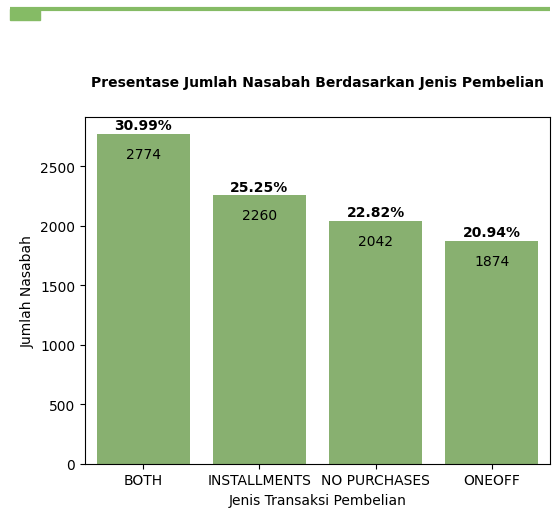

In [13]:
fig, ax = plt.subplots(figsize=(6,4.5))

# garis lurus dan bentuk persegi panjang di atas
fig.add_artist(lines.Line2D([0, 0.9], [1.12, 1.12], lw=3, color=COLOR, solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 1.095), 0.05, 0.025, color=COLOR))

# judul grafik
fig.text(0.135, 0.95, "Presentase Jumlah Nasabah Berdasarkan Jenis Pembelian", fontsize=10, fontweight="bold")

# plot grafik jenis transaksi pembayaran
purchase_type_plot = sns.countplot(
    data=data_eda, 
    x="PURCHASES_TYPE",
    color=COLOR,
    order=data_eda['PURCHASES_TYPE'].value_counts().index
)

# anotasi jumlah nasabah
for bar in purchase_type_plot.patches:
    purchase_type_plot.annotate(
        format(bar.get_height(), '.0f'), (bar.get_x() + bar.get_width() / 2, bar.get_height() + 2), 
        ha='center', 
        va='center',
        size=10, 
        xytext=(0, -15),
        textcoords='offset points')
    
# anotasi persentase jumlah nasabah
for p in purchase_type_plot.patches:
    percentage = f'{100 * p.get_height() / len(data_eda):.2f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    purchase_type_plot.annotate(percentage, (x, y), ha='center', va='center', size=10, fontweight='bold')

plt.xlabel("Jenis Transaksi Pembelian")
plt.ylabel("Jumlah Nasabah")
plt.show()

**_Insight_**:
- Presentase jenis pembelian nasabah Bank Beta cenderung hampir sama pada semua jenis pembelian, yaitu 20%-30% masing-masing jenis pembelian. Namun, presentase yang paling besar ada pada nasabah yang melakukan pembelian secara lunas (ONEOFF) dan angsuran (INSTALLMENTS), yaitu 30.99%. Kemudian, jika dilihat secara keseluruhan presentase nasabah yang menggunakan kartu kredit atau tidak, **presentase nasabah yang sudah menggunakan kartu kredit** mereka untuk melakukan pembelian sebesar **77.18%**, sedangkan nasabah yang sama sekali **tidak menggunakan kartu kredit** untuk melakukan pembelian sebesar **22.82%**.
- **22.82% nasabah tidak melakukan pembelian sama sekali**. Hal ini mengindikasikan nasabah tersebut memiliki kartu kredit hanya untuk kondisi tertentu atau darurat. Untuk mendorong nasabah tersebut menggunakan kartu kredit sebagai sarana pembelian, hal yang dapat dilakukan Bank Beta adalah dengan melakukan penawaran seperti diskon, cashback, atau bunga angsuran yang rendah pada penggunaan pertama.
- **30.99% nasabah melakukan pembelian secara lunas dan angsuran**. Bank Beta dapat memberikan campaign marketing yang berkaitan dengan kedua jenis pembelian tersebut, misalnya bunga yang rendah ketika nasabah melakukan pembelian secara angsuran atau memberikan diskon ketika nasabah melakukan pembelian secara lunas. 
- **25.25% nasabah hanya melakukan pembelian secara angsuran**. Nasabah yang masuk ke dalam presentase tersebut merupakan nasabah yang lebih menyukai melakukan pembelian secara angsuran. Campaign marketing yang mungkin dilakukan untuk nasabah tersebut adalah dengan memberikan bunga angsuran yang kecil.
- **20.94% nasabah hanya melakukan pembelian secara lunas**. Nasabah yang masuk ke dalam presentase tersebut merupakan nasabah yang lebih menyukai melakukan pembelian secara lunas. Campaign marketing yang mungkin dilakukan untuk nasabah tersebut adalah memberikan diskon atau _cashback_ ketika melakukan pembelian secara lunas.
- ......
- ......

>2.3.3. MINIMUM_PAYMENTS vs PAYMENTS

Melihat apakah nasabah Bank Beta masih memiliki tunggakan (tagihan yang belum terbayarkan) pada kartu kredit mereka atau tidak. Jika nasabah yang pembayarannya (PAYMENTS) lebih dari minimal pembayaran (MINIMUM_PAYMENTS), berarti nasabah tersebut tidak memiliki tunggakan. Sebaliknya, jika nasabah yang pembayarannya kurang dari minimal pembayaran, maka nasabah tersebut masih memiliki tunggakan.

In [14]:
# membuat fungsi sebagai conditional statments pada kolom baru PURCHASES_TYPE
def tagihan(df: pd.DataFrame):
    if df['PAYMENTS'] >= df['MINIMUM_PAYMENTS']: return 'Tidak Ada Tagihan'
    elif df['PAYMENTS'] < df['MINIMUM_PAYMENTS']: return 'Ada Tagihan'

data_eda['TAGIHAN'] = data_eda.apply(tagihan, axis=1)
data_eda.sample(5)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,PURCHASES_TYPE,TAGIHAN
4603,C14729,992.615052,1.000000,162.28,0.00,162.28,0.000000,0.500000,0.000000,0.500000,0.000000,0,6,1000.0,333.663574,462.345834,0.00,12,INSTALLMENTS,Ada Tagihan
5510,C15664,1455.904478,0.818182,149.00,149.00,0.00,1991.844526,0.083333,0.083333,0.000000,0.333333,7,1,2200.0,2326.985125,1115.444711,0.00,12,ONEOFF,Tidak Ada Tagihan
6471,C16648,11.725408,0.181818,178.00,178.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1500.0,1024.466785,85.691487,0.00,12,ONEOFF,Tidak Ada Tagihan
1249,C11293,3850.206279,1.000000,2434.50,2372.10,62.40,6742.419844,0.500000,0.333333,0.166667,0.666667,22,22,9000.0,6120.323572,1803.215713,0.00,12,BOTH,Tidak Ada Tagihan
4329,C14450,473.599403,1.000000,524.70,150.32,374.38,1168.556598,1.000000,0.250000,0.750000,0.083333,1,15,1200.0,1772.643444,144.171824,0.25,12,BOTH,Tidak Ada Tagihan


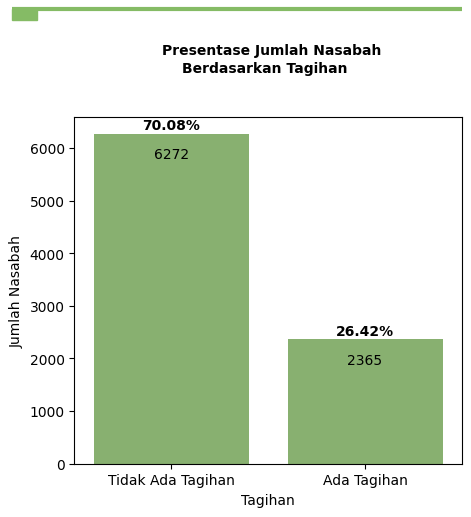

In [15]:
fig, ax = plt.subplots(figsize=(5,4.5))

# garis lurus dan bentuk persegi panjang di atas
fig.add_artist(lines.Line2D([0, 0.9], [1.12, 1.12], lw=3, color=COLOR, solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 1.095), 0.05, 0.025, color=COLOR))

# judul grafik
fig.text(0.3, 1.02, "Presentase Jumlah Nasabah", fontsize=10, fontweight="bold")
fig.text(0.34, 0.98, "Berdasarkan Tagihan", fontsize=10, fontweight="bold")

# plot grafik jenis transaksi pembayaran
angsuran_plot = sns.countplot(
    data=data_eda, 
    x="TAGIHAN",
    color=COLOR,
    order=data_eda['TAGIHAN'].value_counts().index
)

# anotasi jumlah nasabah
for bar in angsuran_plot.patches:
    angsuran_plot.annotate(
        format(bar.get_height(), '.0f'), (bar.get_x() + bar.get_width() / 2, bar.get_height() + 2), 
        ha='center', 
        va='center',
        size=10, 
        xytext=(0, -15),
        textcoords='offset points')
    
# anotasi persentase jumlah nasabah
for p in angsuran_plot.patches:
    percentage = f'{100 * p.get_height() / len(data_eda):.2f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    angsuran_plot.annotate(percentage, (x, y), ha='center', va='center', size=10, fontweight='bold')

plt.xlabel("Tagihan")
plt.ylabel("Jumlah Nasabah")
plt.show()

**_Insight_**:
- 6272 atau 70.08% nasabah telah membayar tagihan setidaknya sebesar minimum pembayaran, bahkan lebih dari minimum pembayarannya, sehingga mereka tidak memiliki tagihan lagi.
- 2365 atau 26.42% nasabah masih memiliki tagihan yang harus dibayarkan.



2.3.4. .......

.....

.....

dst

### 3. Identifikasi _missing values_, data _outlier_, nilai ambigu, dan data duplikat 

#### 3.1. Identifikasi _Missing Values_

In [16]:
# check apakah terdapat kolom yang memiliki missing values
check_missing = data.isna().sum()
count = 0
# cek apakah terdapat nilai 0 (tidak ada missing values)
if any(check_missing.values) == False:
    print("Tidak terdapat \x1B[3mmissing values\x1B[0m")
# print kolom yang memiliki missing values
else:
    print("Terdapat \x1B[3mmissing values\x1B[0m:")
    for cols, jmlh_baris in dict(check_missing).items():
        # collect kolom yang terdapat missing values
        if jmlh_baris > 0:
            count += 1
            print(f"{count}. Sebanyak \x1b[31m{jmlh_baris} baris\x1b[0m atau \x1b[31m{round(jmlh_baris/len(data)*100,3)}%\x1b[0m pada kolom {cols}")

Terdapat missing values:
1. Sebanyak 1 baris atau 0.011% pada kolom CREDIT_LIMIT
2. Sebanyak 313 baris atau 3.497% pada kolom MINIMUM_PAYMENTS


**_Insight_**:
- Terdapat 2 kolom yang memiliki **missing values**, yaitu pada kolom **CREDIT_LIMIT** dan **MINIMUM_PAYMENTS**, masing-masing sebanyak **1 baris atau 0.011%** dan **313 baris atau 3.497%**.

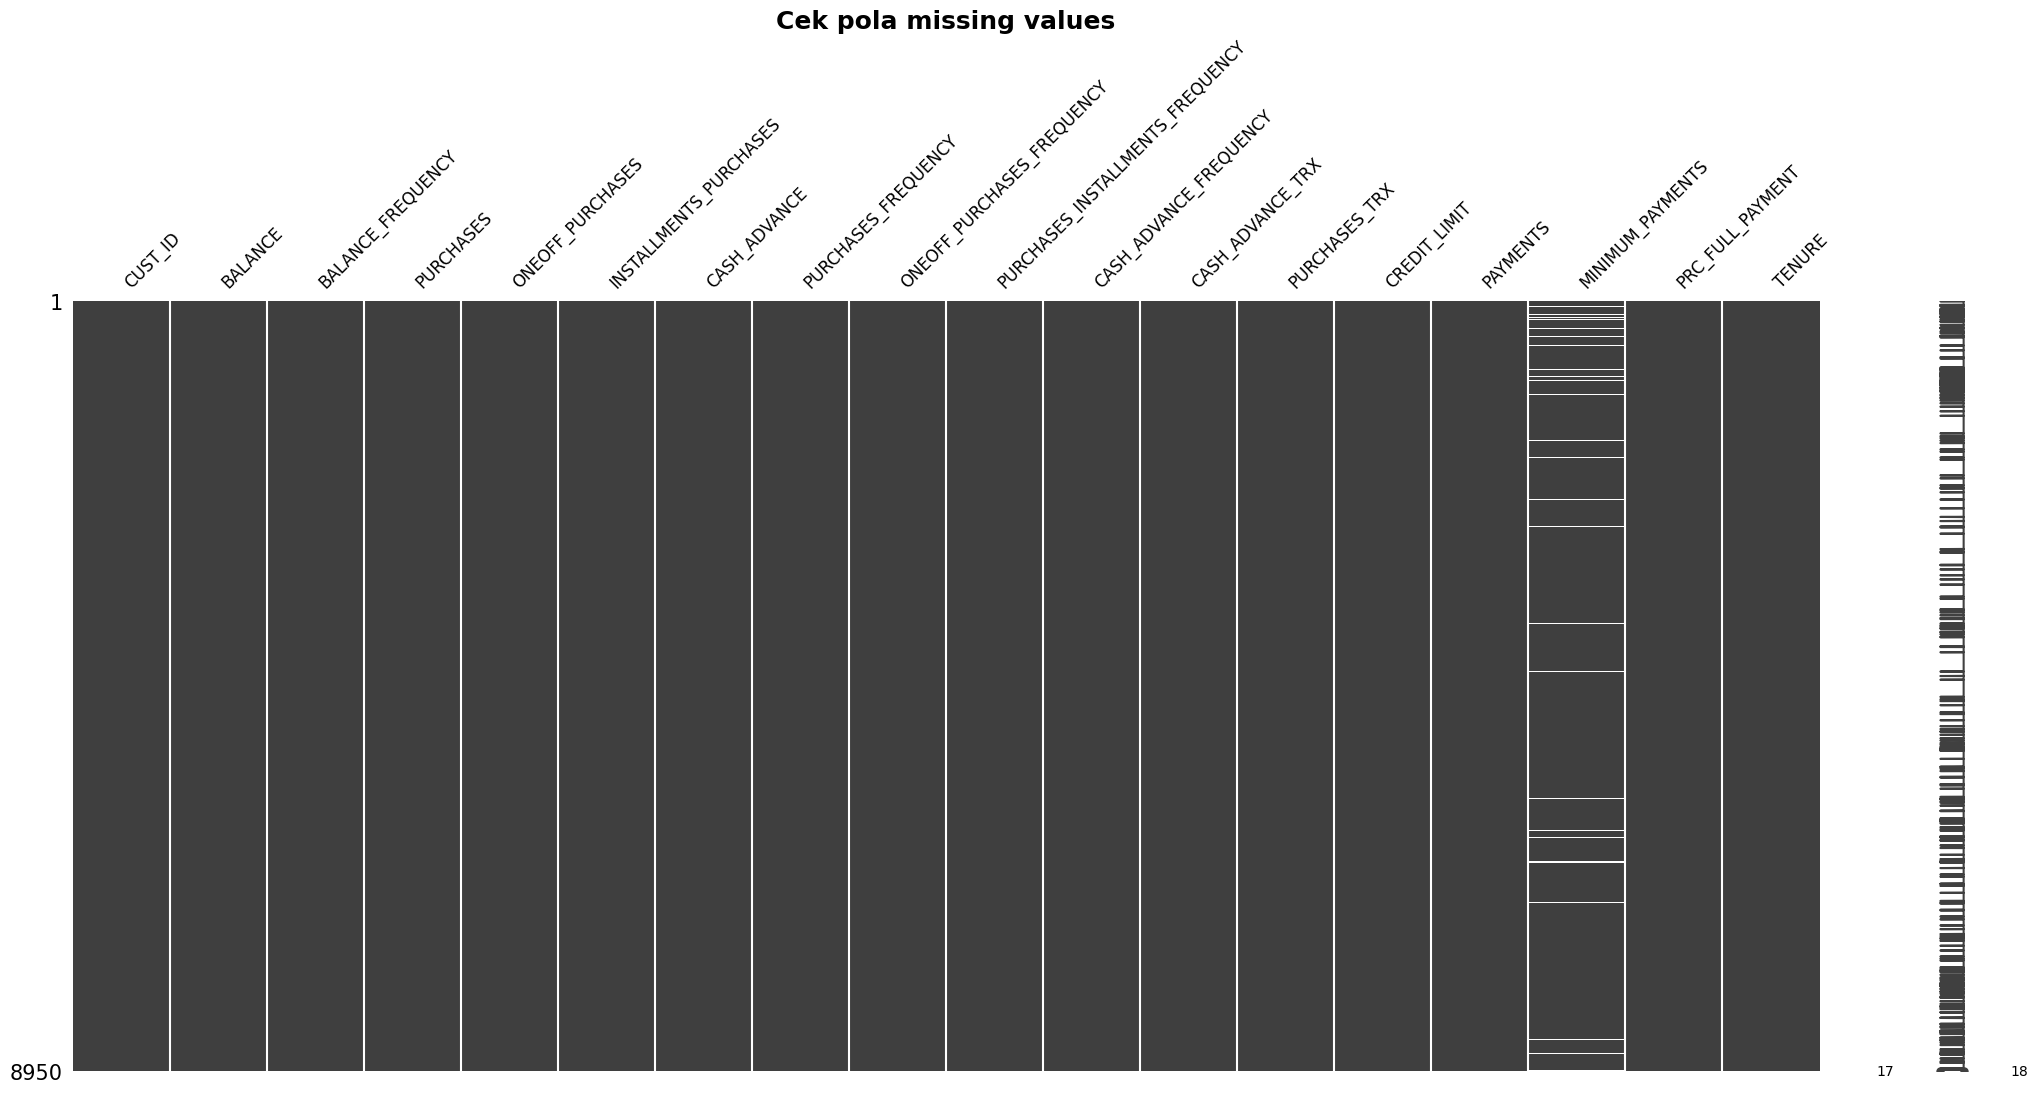

In [17]:
# cek pola missing values dengan menggunakan library missingno matrix
msno.matrix(data, fontsize=12)
plt.title("Cek pola missing values", fontsize=18, weight="bold")
plt.show()

**_Insight_**:
- _Missing values_ tidak menunjukkan pola tertentu terhadap data variabel itu sendiri dan/atau _missing values_ pada variabel variabel lainnya

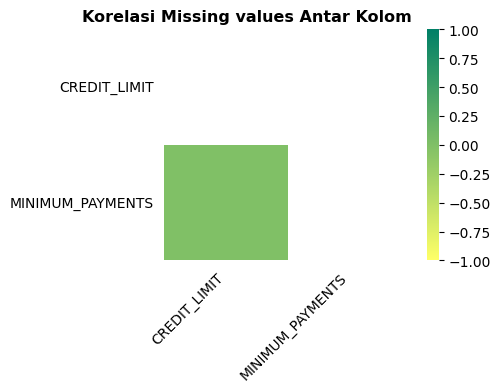

In [18]:
# cek bagaimana korelasi missing values antar kedua kolom tersebut
msno.heatmap(data, cmap=CUSTOM_SUMMER, figsize=(4,3))
# judul grafik
plt.title("Korelasi Missing values Antar Kolom", size=11.5, loc='right', fontweight='bold')
# ukuran xticks dan yticks
plt.xticks(size=10)
plt.yticks(size=10)
# display grafik
plt.show();

**_Insight_**:
- **Tidak ada korelasi** missing values antara kolom CREDIT_LIMIT dan MINIMUM_PAYMENTS

**Note:**
Namun, berdasarkan korelasi data antar kolom di atas (EDA 2.2. Cek Korelasi Data Antar Kolom Menggunakan Metode Spearman) dan diperkuat dengan _domain knowledge_, CREDIT_LIMIT dan MINIMUM_PAYMENTS suatu nasabah dapat dipengaruhi oleh bagaimana riwayat transaksi nasabah tersebut

Referensi:
- [What To Know About Credit Card Minimum Payments](https://www.forbes.com/advisor/credit-cards/credit-card-minimum-payments/#:~:text=In%20this%20case%2C%20the%20minimum,A%20flat%20rate.)
- [What Happens To Your Balance And Credit Score When You Pay Only The Minimum On Your Credit Card?](https://www.forbes.com/advisor/credit-cards/what-happens-to-your-balance-and-credit-score-when-you-pay-only-the-minimum-on-your-credit-card/)
- [What Is a Credit Limit? How It's Determined and How to Increase It](https://www.investopedia.com/terms/c/credit_limit.asp#:~:text=Products%20like%20credit%20cards%20and,typically%20receive%20higher%20credit%20limits.)
- [How Credit Card Issuers Set Your Credit Limit](https://www.forbes.com/advisor/credit-cards/how-credit-card-issuers-set-your-credit-limit/)

#### 3.2. Identifikasi Data Outlier secara _Univariate Analysis_ menggunakan Box Plot dan IQR

Deteksi data _outlier_ secara _univariate_: Melihat apakah suatu data memiliki **nilai yang ekstrem** berdasarkan **hanya** variabel data tersebut.

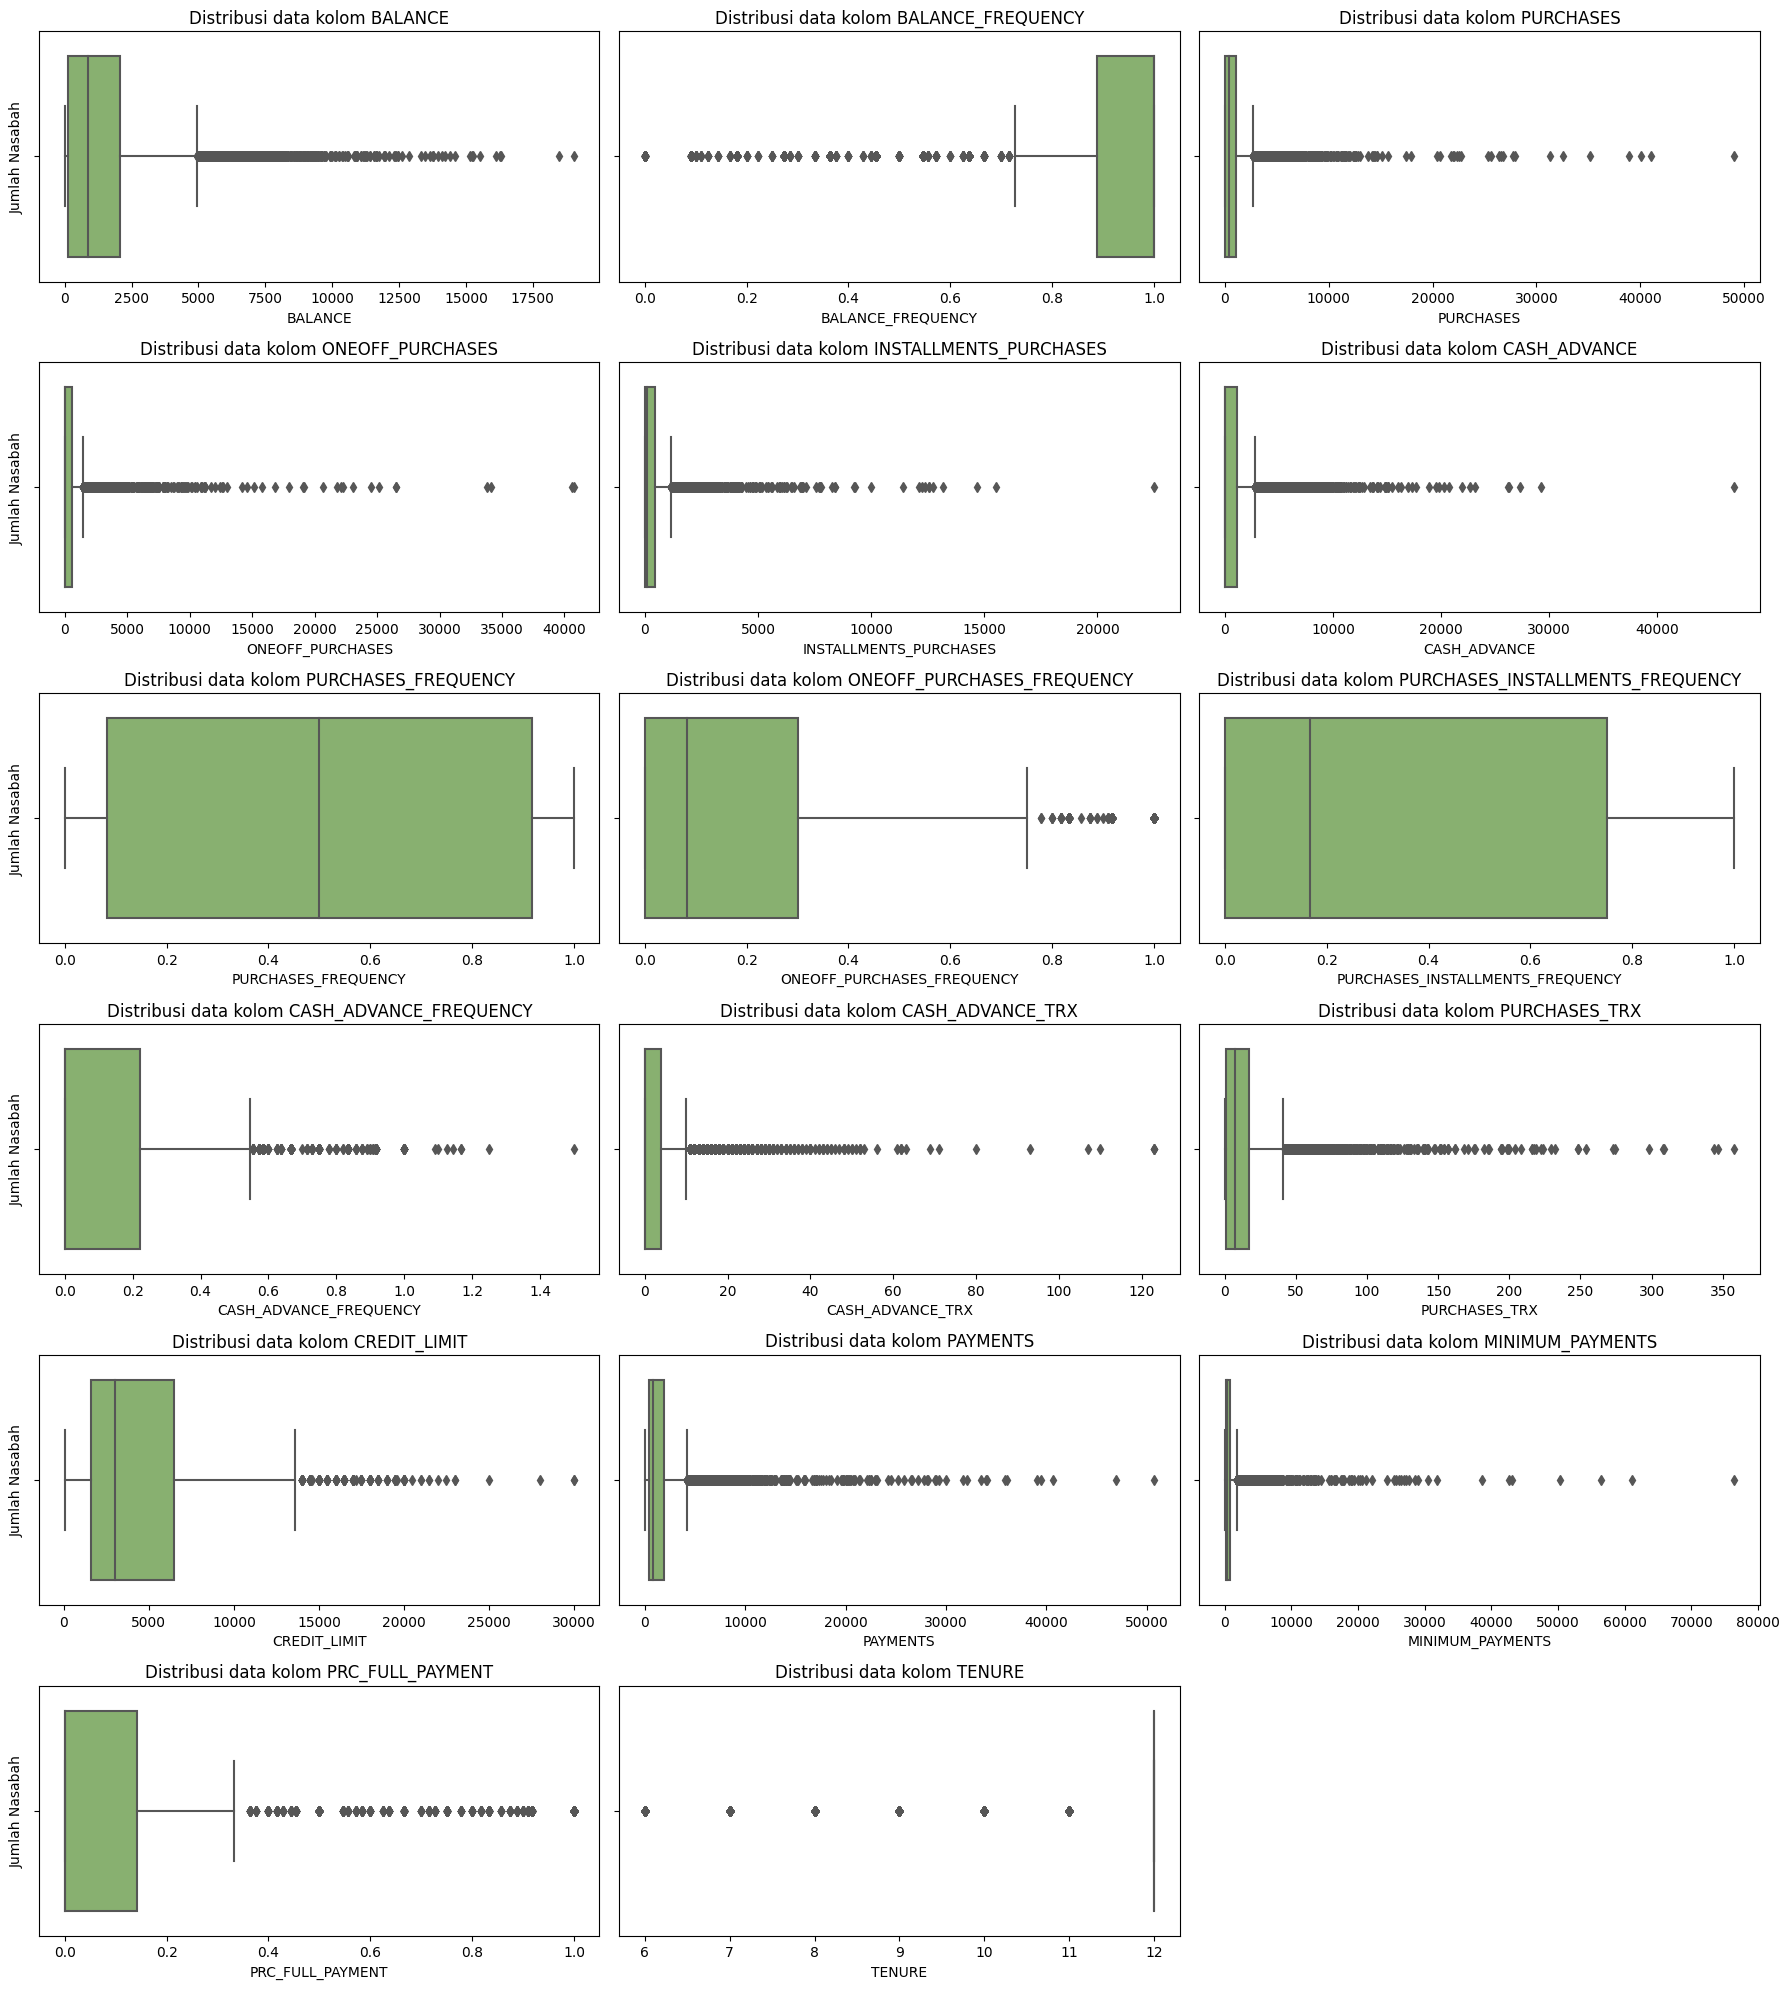

In [19]:
# plot distributi data dari semua kolom menggunakan histogram plot
count = 0
fig = plt.figure(figsize=(18, 20))
for feature in data.drop(columns='CUST_ID').columns:
    count +=1
    ax = plt.subplot(6,3,count)
    sns.boxplot(data=data.drop(columns='CUST_ID'), x=feature, color=COLOR)
    plt.title(f"Distribusi data kolom {feature}")
    if count in [1,4,7,10,13,16]:
        plt.ylabel("Jumlah Nasabah")
    fig.tight_layout()
plt.show()

**_Insight_**:
- Berdasarkan visualiasi grafik di atas, hampir semua kolom memiliki data outlier, kecuali pada kolom PURCHASES_FREQUENCY dan PURCHASES_INSTALLMENTS_FREQUENCY.
- Data outlier pada kolom-kolom tersebut masih dinilai masuk akal/wajar (weak outlier/noise), namun ada beberapa data yang bersifat _strong outlier_ seperti pada kolom CASH_ADVANCE dan INSTALLMENTS_PURCHASES. Kemungkinan hal ini terjadi ketika nasabah tersebut menggunakan kartu kredit untuk keadaan yang sangat darurat.
- ......
- ......

Referensi: [C. C. Aggarwal, "An Introduction to Outlier Analysis" in Outlier Analysis, 2nd ed. New York, USA: Springer Nature, 2017, pp.3.](https://charuaggarwal.net/outlierbook.pdf)

In [20]:
# cek presentase data outlier pada kolom yang memiliki data outlier
cols = data.drop(columns='CUST_ID').columns
result = []

# cek data outlier untuk semua kolom
for index, column in enumerate(cols):
    # variabel-variabel untuk cek data outlier
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (IQR*1.5)
    upper_bound = Q3 + (IQR*1.5)
    # kondisi untuk data yang outlier
    condition = (data[column] < lower_bound) | (data[column] > upper_bound)
    # jumlah data outlier (jika ada)
    n_data_outlier = data.loc[condition, column].count()
    # presentase jumlah data outlier (jika ada)
    prc_data_outlier = n_data_outlier/data[column].count()*100
    # conditional statements untuk cek apakah data tersebut mengandung outlier atau tidak
    # jika tidak terdapat outlier
    if n_data_outlier == 0:
        result.append({'kolom': column, 'n_baris':n_data_outlier, 'prc_baris':prc_data_outlier, 'keterangan':'TIDAK terdapat data outlier'})
    # jika terdapat outlier (> 0% s/d 10%)
    elif prc_data_outlier > 0 and prc_data_outlier < 10:
        result.append({'kolom': column, 'n_baris':n_data_outlier, 'prc_baris':prc_data_outlier, 'keterangan':"terdapat data outlier (0% - 10%)"})
    else:
        result.append({'kolom': column, 'n_baris':n_data_outlier, 'prc_baris':prc_data_outlier, 'keterangan':"terdapat data outlier (> 10%)"})

# DataFrame data outlier
outlier_result = pd.DataFrame(result)
# sort berdasarkan prc_baris Z - A
outlier_result.sort_values('prc_baris', ascending=False)\
    .style.highlight_between(subset='prc_baris', axis=1, left=10, props='color:#080808;font-weight:bold;background-color:#85bb65')

,kolom,n_baris,prc_baris,keterangan
1,BALANCE_FREQUENCY,1493,16.681564,terdapat data outlier (> 10%)
15,PRC_FULL_PAYMENT,1474,16.469274,terdapat data outlier (> 10%)
16,TENURE,1366,15.262570,terdapat data outlier (> 10%)
5,CASH_ADVANCE,1030,11.508380,terdapat data outlier (> 10%)
3,ONEOFF_PURCHASES,1013,11.318436,terdapat data outlier (> 10%)
14,MINIMUM_PAYMENTS,841,9.737177,terdapat data outlier (0% - 10%)
4,INSTALLMENTS_PURCHASES,867,9.687151,terdapat data outlier (0% - 10%)
13,PAYMENTS,808,9.027933,terdapat data outlier (0% - 10%)
2,PURCHASES,808,9.027933,terdapat data outlier (0% - 10%)
10,CASH_ADVANCE_TRX,804,8.983240,terdapat data outlier (0% - 10%)


**_Insight_**:
- Kolom-kolom yang memiliki data outlier, rentang presentase datanya mulai dari **2%-16.68%** dari total data (8950 data)
- Kolom yang memiliki data outlier sebanyak **lebih dari 10%**: BALANCE_FREQUENCY, PRC_FULL_PAYMENT, TENURE, CASH_ADVANCE, dan ONEOFF_PURCHASES. Selain itu, lebih kecil dari 10%
- Terdapat pola pada data outlier PURCHASES dan PAYMENTS, yaitu jumlah datanya sama besar, yaitu 808 baris atau 9.03% dari total nasabah

In [21]:
# cek lebih lanjut apakah data nasabah yang termasuk outlier tersebut merupakan nasabah yang sama atau mungkin ada yang sama, jika dilihat berdasarkan kolom PURCHASES dan PAYMENTS
col_list = ['PURCHASES', 'PAYMENTS']
# data outlier nasabah PURCHASES
data_out_PURCHASES = ''
# data outlier nasabah PAYMENTS
data_out_PAYMENTS = ''
for column in col_list:
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (IQR*1.5)
    upper_bound = Q3 + (IQR*1.5)
    condition = (data[column] < lower_bound) | (data[column] > upper_bound)
    data_nasabah = data.loc[condition, 'CUST_ID'].values
    if column == 'PURCHASES':
        # collect CUST_ID data nasabah yang termasuk outlier pada kolom PURCHASES
        data_out_PURCHASES = data_nasabah
    else:
        # collect CUST_ID data nasabah yang termasuk outlier pada kolom PAYMENTS
        data_out_PAYMENTS = data_nasabah

# cek CUST_ID nasabah yang termasuk outlier pada kolom PURCHASES ada di PAYMENTS juga
nasabah_sama = 0
for cust_id in data_out_PURCHASES:
    if cust_id in data_out_PAYMENTS:
        nasabah_sama +=1
    else:
        continue
print(f"Jumlah nasabah yang sama sebanyak {nasabah_sama} nasabah ({round(((nasabah_sama/len(data))*100),3)}% dari total nasabah)")

Jumlah nasabah yang sama sebanyak 356 nasabah (3.978% dari total nasabah)


**_Insight_**:
- Ternyata terdapat **3.978% dari total nasabah atau 356 nasabah yang sama** pada data outlier berdasarkan kolom PURCHASES dan PAYMENTS. Nasabah ini merupakan nasabah yang melakukan pembelian (PURCHASES) dan total tagihan yang dibayarkan (PAYMENTS) lebih besar daripada nasabah lain pada umumnya

#### 3.3. Identifikasi nilai ambigu (Ambigous Values)

Mengidentifikasi apakah nilai-nilai atau data pada setiap kolom wajar atau tidak. Pada kolom-kolom yang bersifat frekuensi, seperti PURCHASES FREQUENCY, BALANCE_FREQUENCY, ONEOFF_PURCHASES_FREQUENCY, dsb, jika dilihat dari tipe data dan nilai-nilainya, menunjukkan bahwa bahwa kolom tersebut bersifat _relative frequency_, yaitu nilai proporsi/persentase/fraksi dari suatu jumlah data tertentu terhadap jumlah total data. **Nilainya harus berada diantara 0 dan 1.**

Referensi:
- [Stephanie Glen. "Relative Frequency Distribution: Definition and Examples" From StatisticsHowTo.com: Elementary Statistics for the rest of us!](https://www.statisticshowto.com/probability-and-statistics/statistics-definitions/relative-frequency-distribution/)
- [Kaeli Gardner. "What is Relative Frequency?" From study.com](https://study.com/learn/lesson/what-is-relative-frequency.html#:~:text=Well%2C%20the%20relative,proportion%20or%20percentage.)
- [Difference Between Frequency and Relative Frequency](https://www.geeksforgeeks.org/difference-between-frequency-and-relative-frequency/#:~:text=Relative%20frequency%20is%20the%20proportion%20or%20percentage%20of%20times%20a%20specific%20value%20or%20category%20appears%20in%20a%20dataset.)

In [22]:
freq_column = ['BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY']
pd.DataFrame(
                {
                'kolom': data[freq_column].columns.values,
                'min': data[freq_column].min().values,
                'max': data[freq_column].max().values,
                'sample_unique': [data[col].unique() for col in data[freq_column].columns]
                }
            )

,kolom,min,max,sample_unique
0,BALANCE_FREQUENCY,0.0,1.0,"[0.818182, 0.909091, 1.0, 0.636364, 0.545455, ..."
1,PURCHASES_FREQUENCY,0.0,1.0,"[0.166667, 0.0, 1.0, 0.083333, 0.666667, 0.333..."
2,ONEOFF_PURCHASES_FREQUENCY,0.0,1.0,"[0.0, 1.0, 0.083333, 0.166667, 0.25, 0.916667,..."
3,PURCHASES_INSTALLMENTS_FREQUENCY,0.0,1.0,"[0.083333, 0.0, 0.583333, 1.0, 0.25, 0.916667,..."
4,CASH_ADVANCE_FREQUENCY,0.0,1.5,"[0.0, 0.25, 0.083333, 0.166667, 0.333333, 0.36..."


**_Insight_**:
- Berdasarkan referensi di atas, terdapat **nilai yang ambigu** pada kolom **CASH_ADVANCE_FREQUENCY karena memiliki nilai maksimal 1.5**. Padahal berdasarkan teori, seharusnya nilai maksimal dari suatu data yang bersifat _relative frequency_ adalah 1

#### 3.4. Identifikasi Data Duplikat

Karena nantinya kolom CUST_ID tidak digunakan untuk analisa selanjutnya, maka pengecekan duplikat data juga tanpa kolom CUST_ID. Hal ini juga berguna untuk memastikan apakah terdapat data nasabah yang tercatat lebih dari 1 kali, walaupun CUST_ID-nya berbeda, jika ada, kemungkinan telah terjadi _human error_ atau _bug_ pada sistem ketika proses memasukan data nasabah tersebut.

In [23]:
# cek duplikat data tanpa kolom CUST_ID
if data.drop(columns='CUST_ID').loc[data.duplicated()].shape[0] != 0:
    # menampilkan DataFrame yang memiliki data duplikat
    display(data.drop(columns='CUST_ID').loc[data.duplicated()])
    print(f"Terdapat data duplikat sebanyak: \x1b[31m{data.drop(columns='CUST_ID').loc[data.duplicated()].shape[0]} baris\x1b[0m")
else:
    # menampilkan DataFrame
    display(data.drop(columns='CUST_ID').loc[data.duplicated()])
    print("Tidak terdapat data duplikat")

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE


Tidak terdapat data duplikat


## `Preprocessing`

In [24]:
# copy dataset ke dalam variabel lain, agar tidak mengubah dataset aslinya. Hal ini bertujuan jika nantinya terdapat analisa yang mengharuskan membandingkan dengan dataset aslinya
data_preprocess = data.copy()

### 1. _Handling_ Nilai Ambigu pada kolom CASH_ADVANCE_FREQUENCY

In [25]:
# tampilkan data nasabah yang CASH_ADVANCE_FREQUENCY lebih dari 1
display(data_preprocess.query("CASH_ADVANCE_FREQUENCY > 1")[['CUST_ID', 'CASH_ADVANCE_FREQUENCY']])
# collect CUST_ID yang CASH_ADVANCE_FREQUENCY lebih dari 1
ambigu_cust_id = data_preprocess.query("CASH_ADVANCE_FREQUENCY > 1")['CUST_ID'].values
ambigu_cust_id

,CUST_ID,CASH_ADVANCE_FREQUENCY
681,C10708,1.250000
1626,C11680,1.166667
2555,C12629,1.125000
2608,C12684,1.100000
3038,C13127,1.500000
3253,C13347,1.166667
8055,C18273,1.090909
8365,C18588,1.142857


array(['C10708', 'C11680', 'C12629', 'C12684', 'C13127', 'C13347',
       'C18273', 'C18588'], dtype=object)

In [26]:
# mengganti nilai yang lebih dari 1 pada kolom CASH_ADVANCE_FREQUENCY dengan 1, karena 1 merupakan nilai maksimal
data_preprocess.loc[data_preprocess['CASH_ADVANCE_FREQUENCY'] > 1, 'CASH_ADVANCE_FREQUENCY'] = 1

# memastikan data sudah diganti dengan 1
if data_preprocess.query("CASH_ADVANCE_FREQUENCY > 1").shape[0] > 0:
    # tampilkan data yang masih belum terganti
    display(data_preprocess.query("CASH_ADVANCE_FREQUENCY > 1")[['CUST_ID', 'CASH_ADVANCE_FREQUENCY']])
    print("Masih terdapat nilai CASH_ADVANCE_FREQUENCY yang lebih dari 1")
elif data_preprocess.query("CASH_ADVANCE_FREQUENCY > 1").shape[0] == 0:
    # tampilkan data yang sudah terganti
    display(data_preprocess.query("CUST_ID.isin(@ambigu_cust_id)")[['CUST_ID', 'CASH_ADVANCE_FREQUENCY']])
    print("Nilai CASH_ADVANCE_FREQUENCY yang lebih dari 1 sudah berhasil diganti menjadi 1")

,CUST_ID,CASH_ADVANCE_FREQUENCY
681,C10708,1.0
1626,C11680,1.0
2555,C12629,1.0
2608,C12684,1.0
3038,C13127,1.0
3253,C13347,1.0
8055,C18273,1.0
8365,C18588,1.0


Nilai CASH_ADVANCE_FREQUENCY yang lebih dari 1 sudah berhasil diganti menjadi 1


### 2. Drop Kolom

Seperti yang telah disebutkan di atas, kolom CUST_ID merupakah kolom unique ID para nasabah yang diberikan oleh pihak Bank, agar dapat dibedakan antar satu nasabah dengan nasabah yang lain. Unique ID pada dataset ini tidak ada yang duplikat atau dengan kata lain tidak ada data nasabah yang tercatat lebih dari 1 kali. **Kolom CUST_ID tidak memberikan informasi yang berkaitan dengan perilaku bagaimana nasabah menggunakan kartu kreditnya**. Kemudian, untuk analisa selanjutnya juga tidak diperlukan kolom CUST_ID, sehingga tim Data Scientist tidak menggunakan kolom tersebut untuk proses analisa selanjutnya.

#### 2.1. Kolom CUST_ID

In [27]:
# menghapus kolom CUST_ID
data_preprocess = data_preprocess.drop(columns='CUST_ID')

# cek apakah masih terdapat kolom CUST_ID atau tidak
if 'CUST_ID' in list(data_preprocess.columns):
    print("Kolom CUST_ID \x1b[31mmasih\x1b[0m terdapat pada dataset")
else:
    print("Kolom CUST_ID berhasil \x1b[31mdihapus\x1b[0m dari dataset")

Kolom CUST_ID berhasil dihapus dari dataset


### 3. _Handling_ Data Outlier

### 4. _Handling Missing Values_

Berdasarkan temuan pada EDA di atas dan akan melakukan _clustering_ pada proses selanjutnya, maka _handling missing values_ akan menggunakan metode **KNNImputer** menggunakan _package_ scikit-learn

In [28]:
# scaling ulang menggunakan MinMaxScaler
scaler_minmax = MinMaxScaler()
# imputasi missing values menggunakan KNNImputer
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# DataFrame yang sudah discaling dengan scaler
scaled_data_preprocess = pd.DataFrame(scaler_minmax.fit_transform(data_preprocess), columns=data_preprocess.columns)
# melakukan imputasi missing values
imputed_data_preprocess = pd.DataFrame(knn_imputer.fit_transform(data_preprocess), columns=data_preprocess.columns)
# # inverse hasil scaler menjadi nilai aslinya
# inverse_imputed = pd.DataFrame(scaler_minmax.inverse_transform(imputed_data_preprocess), columns=data_preprocess.columns)

# cek kembali apakah masih terdapat missing values
check_missing_preprocess = imputed_data_preprocess.isna().sum()
count = 0
# cek apakah terdapat nilai 0 (tidak ada missing values)
if any(check_missing_preprocess.values) == False:
    print("Tidak terdapat \x1B[3mmissing values\x1B[0m")
# print kolom yang memiliki missing values
else:
    print("Terdapat \x1B[3mmissing values\x1B[0m:")
    for cols, jmlh_baris in dict(check_missing_preprocess).items():
        # collect kolom yang terdapat missing values
        if jmlh_baris > 0:
            count += 1
            print(f"{count}. Sebanyak \x1b[31m{jmlh_baris} baris\x1b[0m atau \x1b[31m{round(jmlh_baris/len(data)*100,3)}%\x1b[0m pada kolom {cols}")

Tidak terdapat missing values


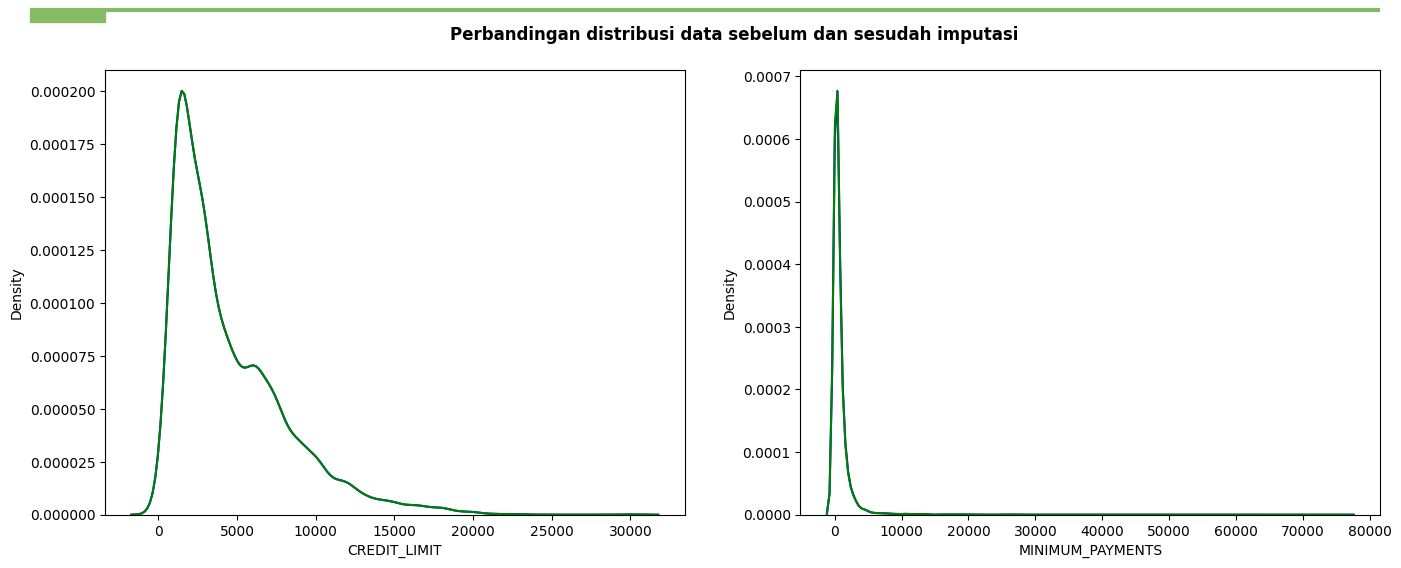

In [29]:
# inisialisasi plot
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

# adjust subplot
plt.subplots_adjust(left=0.05, top=1)

# garis lurus dan bentuk persegi panjang di atas
fig.add_artist(lines.Line2D([0, 0.9], [1.12, 1.12], lw=3, color=COLOR, solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 1.095), 0.05, 0.025, color=COLOR))

# judul grafik
fig.text(0.28, 1.06, "Perbandingan distribusi data sebelum dan sesudah imputasi", fontsize=12, fontweight="bold")

# display grafik CREDIT_LIMIT
sns.distplot(data['CREDIT_LIMIT'], kde=True, hist=False, color='blue', ax=ax1) # sebelum imputasi
sns.distplot(imputed_data_preprocess['CREDIT_LIMIT'], kde=True, hist=False, color='green', ax=ax1) # sesudah imputasi

# display grafik MINIMUM_PAYMENTS
sns.distplot(data['MINIMUM_PAYMENTS'], kde=True, hist=False, color='blue', ax=ax2) # sebelum imputasi
sns.distplot(imputed_data_preprocess['MINIMUM_PAYMENTS'], kde=True, hist=False, color='green', ax=ax2) # sesudah imputasi

plt.show()

**Insight**:
- Berdasarkan grafik distribusi di atas, dapat dilihat bahwa setelah melakukan imputasi, distribusi data **masih sama dengan** sebelum melakukan imputasi

Melakukan uji statistik _Two Sample Kolmogorov-Smirnov Test_ untuk memperkuat analisa di atas dan melihat apakah distribusi data setelah dilakukan imputasi **berbeda atau sama** dengan distribusi data sebelum dilakukan imputasi berdasarkan nilai _pvalue_

Hipotesis:
- Ho : Distribusi data sebelum dilakukan imputasi = distribusi data setelah dilakukan imputasi
- H1 : Distribusi data sebelum dilakukan imputasi ≠ distribusi data setelah dilakukan imputasi

significance level (alpha) = 0.05

Referensi:
- [How to Perform a Kolmogorov-Smirnov Test in Python](https://www.statology.org/kolmogorov-smirnov-test-python/)
- [scipy.stats.ks_2samp documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html)

In [30]:
result1 = []
col_missing = ['CREDIT_LIMIT', 'MINIMUM_PAYMENTS']
for col in col_missing:
    # membandingkan 
    stats1, pvalue1 = ks_2samp(data[col].dropna(), imputed_data_preprocess[col], alternative='two-sided')

    # check the hypothesis:
    # Menerima H0
    if pvalue1 > 0.05:
        result1.append({'kolom':col,'significance_level':0.05,'pvalue':pvalue1, 'distribusi sebelum & sesudah': 'distribusi data sama'})
        # print(f"pvalue: {pvalue1}. Jadi, kami punya cukup bukti untuk mengatakan bahwa {col} pada DataFrame SEBELUM and SESUDAH \x1B[3mhandling missing values\x1B[0m memiliki distribusi yang \x1b[31msama\x1b[0m")
    # Menolak H0
    else:
        result1.append({'kolom':col, 'significance_level':0.05, 'pvalue':pvalue1, 'distribusi sebelum & sesudah': 'distribusi data berbeda'})
        # print(f"pvalue: {pvalue1}. Jadi, kami punya cukup bukti untuk mengatakan bahwa {col} pada DataFrame SEBELUM and SESUDAH \x1B[3mhandling missing values\x1B[0m memiliki distribusi yang \x1b[31mberbeda\x1b[0m")

# display hasil uji statistik
pd.DataFrame(result1)

,kolom,significance_level,pvalue,distribusi sebelum & sesudah
0,CREDIT_LIMIT,0.05,1.000000,distribusi data sama
1,MINIMUM_PAYMENTS,0.05,0.457845,distribusi data sama


**_Insight_**:
- Setelah melakukan imputasi menggunakan KNNImputer, distribusi data **masih sama dengan** ketika sebelum melakukan imputasi

In [32]:
# temporary cleaned dataset
imputed_data_preprocess.to_csv("../data/processed/clean_cc_data.csv", index=False)

---------
---------
---------